# Machine Learning and Computational Statistics – Project

### Student: Charalambos Sykianakis
### Registration Number: p3352224
### E-mail: xsykianakis@aueb.gr


In [47]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn import linear_model
from scipy.optimize import nnls
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from cvxopt import solvers, matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture

### Loading dataframes

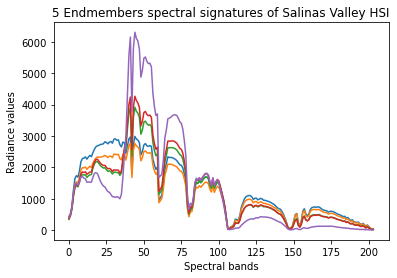

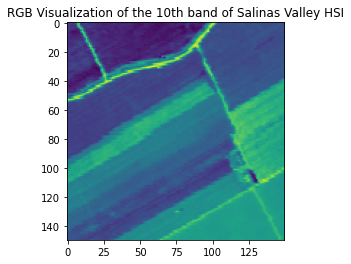

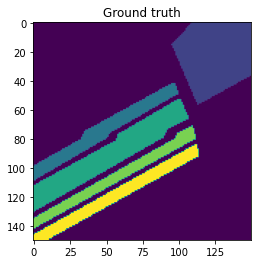

In [14]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['Salinas_cube'] #Salinas HSI : 150x150x204
Endmembers = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x5
endmembers = Endmembers['Salinas_endmembers']

ground_truth=sio.loadmat('Salinas_ground_truth.mat')
labels = ground_truth['salinas_gt']


fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('5 Endmembers spectral signatures of Salinas Valley HSI')
plt.show()

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas Valley HSI')
plt.show()


fig = plt.figure()
plt.imshow(labels)
plt.title('Ground truth')
plt.show()

# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

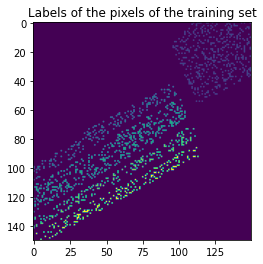

In [15]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels.mat')
Training_Set = (np.reshape(Salinas_labels['Training_Set'],(150,150))).T
Test_Set = (np.reshape(Salinas_labels['Test_Set'],(150,150))).T
Operational_Set = (np.reshape(Salinas_labels['Operational_Set'],(150,150))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [16]:
# pip install cvxopt

# UNMIXING

## (A)

## The purpose here is to obtain for each method the 5 adundance maps, and the reconstruction error.

In [17]:
Y = HSI
X = endmembers

In [18]:
M = 150 # number of rows
N = 150 # number of columns
m = 5   # number of endmembers

### (i) The first method we will use is the Least Square without constrains.

The reconstruction error of the Least Square method is:  52802.459033295396


Text(0.5, 0.98, 'Abundance Maps')

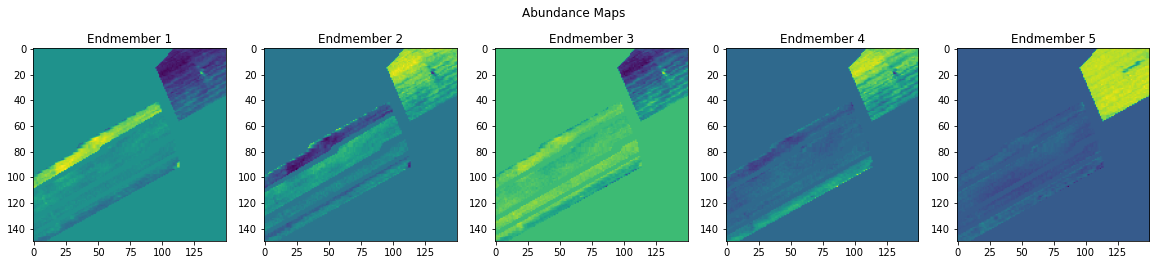

In [19]:
# Initialize the abundance maps and reconstruction errors
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

# Loop over all the pixels in the image
for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            # Extract the spectral signature of the pixel
            y = HSI[i, j, :]
            # Solve the least-squares problem to obtain the abundance vector
            theta = np.linalg.lstsq(X, y, rcond=None)[0]

            # Compute the reconstruction error for the pixel
            y_hat = np.dot(X, theta)
            recon_error = np.linalg.norm(y - y_hat) ** 2
        
            recon_errors[i, j] = recon_error

            # Store the abundance vector in the corresponding map
            abundance_maps[i, j, :] = theta

# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the Least Square method is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]
    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

### (ii) The second method we will use is the Least Square with constrain that the sum of the values of vector θ should sum-to-one. Since each θ this is the % each class
### contributes to the creation of the image, and we have decided that we will unmix the image into 5 classes, this constrain seems logicacl.

In [20]:
P = matrix(np.dot(X.T, X))
q= - matrix(np.dot(X.T, y))

In [21]:
A = matrix([[1.0],[1.0],[1.0],[1.0],[1.0]])# Equality constraint matrix for sum-to-one
b = matrix([1.0])  # Equality constraint vector for sum-to-one

G = matrix([[-1.0,0.0,0.0,0.0,0.0],[0.0,-1.0,0.0,0.0,0.0],[0.0,0.0,-1.0,0.0,0.0],[0.0,0.0,0.0,-1.0,0.0],[0.0,0.0,0.0,0.0,-1.0]])
# non negative,we use -1 because by default cvxopt calculates for negative constrain <0
h = matrix([0.0,0.0,0.0,0.0,0.0])# non negative

The reconstruction error of the Least Square (sum to one) method is:  79685.81258224233


Text(0.5, 0.98, 'Abundance Maps')

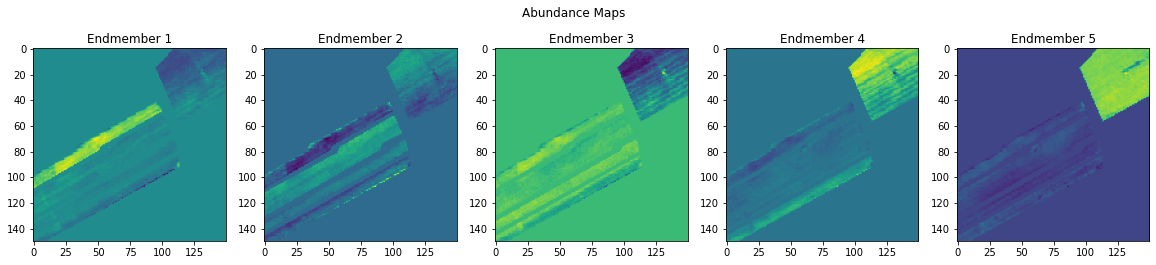

In [22]:
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            # Extract the spectral signature of the pixel
            y = HSI[i, j, :].reshape(-1,1)
            q= - matrix(np.dot(X.T, y))
            solvers.options['show_progress'] = False
            sol=solvers.qp(P,q,None,None,A,b)
            theta=sol['x']
            # Compute the reconstruction error for the pixel
            y_hat = np.dot(X, theta)
            recon_error = np.linalg.norm(y - y_hat) ** 2
        
            recon_errors[i, j] = recon_error
            t=np.array(theta)
            t=np.transpose(t)
            # Store the abundance vector in the corresponding map
            abundance_maps[i, j, :] = t

# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the Least Square (sum to one) method is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]

    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

### (iii) The third method we will use is the Least Square with constrain that the values of vector θ should not be negative.
###       Since each value of vector θ cannot contribute to the image negatively, this is a constrain that also make sence.

The reconstruction error of the Least Square (non-negativity constraint on the entries of θ) method is:  423495.98255135975


Text(0.5, 0.98, 'Abundance Maps')

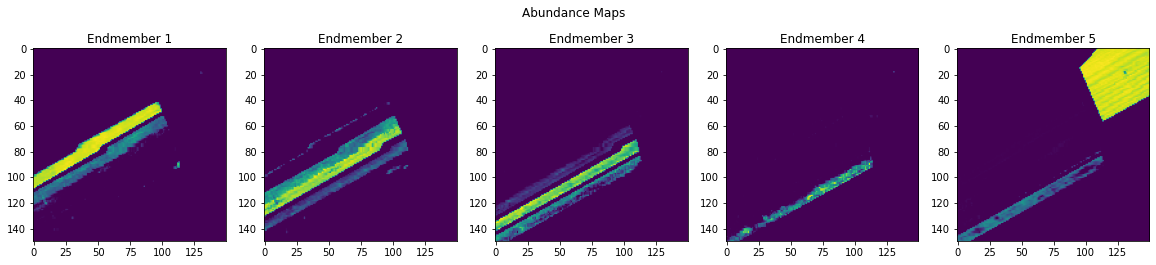

In [23]:
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            # Extract the spectral signature of the pixel
            y = HSI[i, j, :].reshape(-1,1)
            q= - matrix(np.dot(X.T, y))
            solvers.options['show_progress'] = False
            sol=solvers.qp(P,q,G,h,None,None)
            theta=sol['x']
            # Compute the reconstruction error for the pixel
            y_hat = np.dot(X, theta)
            recon_error = np.linalg.norm(y - y_hat) ** 2
        
            recon_errors[i, j] = recon_error
            t=np.array(theta)
            t=np.transpose(t)
            # Store the abundance vector in the corresponding map
            abundance_maps[i, j, :] = t

# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the Least Square (non-negativity constraint on the entries of θ) method is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]

    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

### (iv) The fourth method we will use is the Least Square including both previous constrains sum to one and non negative for θ.

The reconstruction error of the Least Square (non-negativity and the sum-to-one constraint on the entries of θ) method is:  2621758.165123007


Text(0.5, 0.98, 'Abundance Maps')

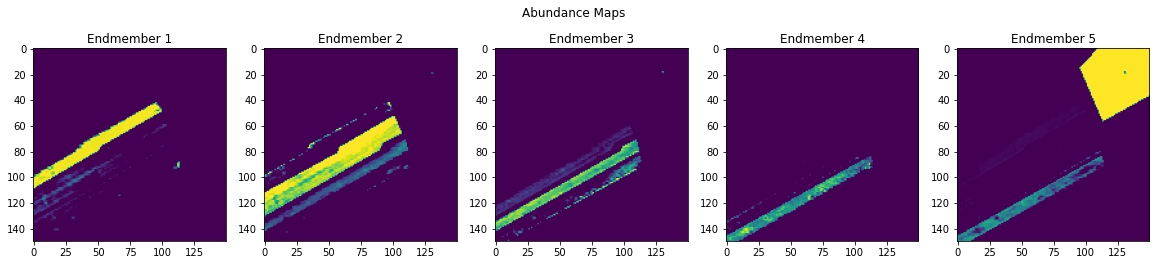

In [24]:
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            # Extract the spectral signature of the pixel
            y = HSI[i, j, :].reshape(-1,1)
            q= - matrix(np.dot(X.T, y))
            solvers.options['show_progress'] = False
            sol=solvers.qp(P,q,G,h,A,b)
            theta=sol['x']
            # Compute the reconstruction error for the pixel
            y_hat = np.dot(X, theta)
            recon_error = np.linalg.norm(y - y_hat) ** 2
        
            recon_errors[i, j] = recon_error
            t=np.array(theta)
            t=np.transpose(t)
            # Store the abundance vector in the corresponding map
            abundance_maps[i, j, :] = t

# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the Least Square (non-negativity and the sum-to-one constraint on the entries of θ) method is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]

    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

### (v) Lastly we will use LASSO, which is a regression that gives the ability to eliminate the (total 0) the effect of some features of the problem.

The reconstruction error of the LASSO method is:  141119.84948243544


Text(0.5, 0.98, 'Abundance Maps')

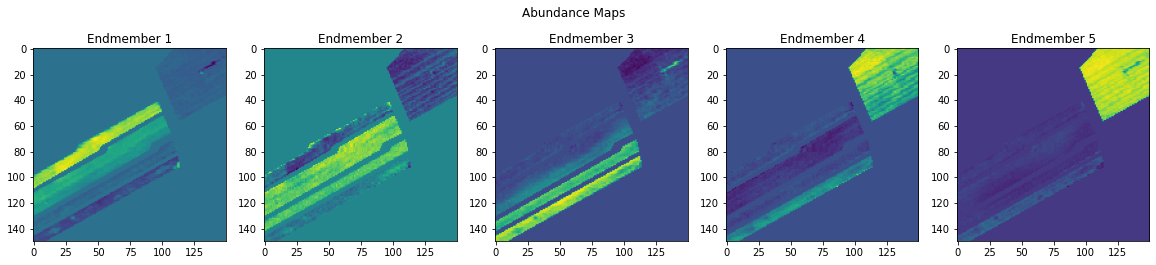

In [25]:
# Initialize the abundance maps and reconstruction errors
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

clf = linear_model.Lasso()
# Loop over all the pixels in the image
for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            y_label = Y[i,j,:].reshape(-1,1)
            clf.fit(X,y_label)
            theta_Lasso = clf.coef_
            y_hat = np.dot(X, theta_Lasso)
            recon_error = np.linalg.norm(Y[i,j,:] - y_hat) ** 2
            recon_errors[i, j] = recon_error
            abundance_maps[i, j, :] = theta_Lasso
            
# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the LASSO method is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]
    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

The reconstruction error of the LASSO method (non-negative) is:  495228.013546872


Text(0.5, 0.98, 'Abundance Maps')

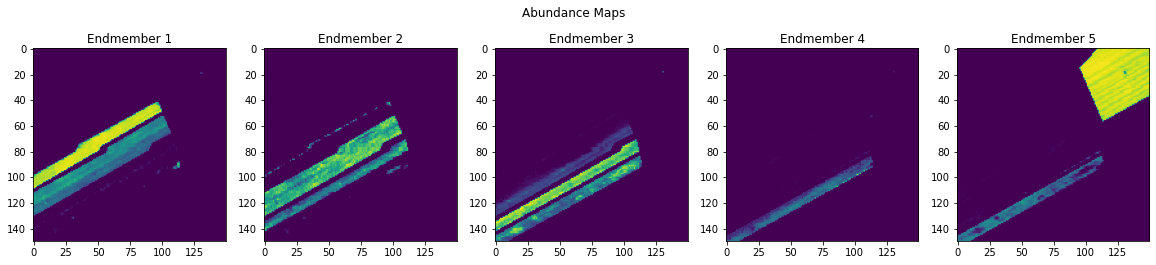

In [45]:
# Initialize the abundance maps and reconstruction errors
abundance_maps = np.zeros((M, N, m))
recon_errors = np.zeros((M, N))

clf = linear_model.Lasso(alpha = 100, positive = True)
# Loop over all the pixels in the image
for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            y_label = Y[i,j,:].reshape(-1,1)
            clf.fit(X,y_label)
            theta_Lasso = clf.coef_
            y_hat = np.dot(X, theta_Lasso)
            recon_error = np.linalg.norm(Y[i,j,:] - y_hat) ** 2
            recon_errors[i, j] = recon_error
            abundance_maps[i, j, :] = theta_Lasso
            
# Compute the average reconstruction error over all pixels
avg_recon_error = np.mean(recon_errors)

print('The reconstruction error of the LASSO method (non-negative) is: ' ,avg_recon_error)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop over the abundance maps and plot each one in a subplot
for i in range(5):
    # Get the abundance map for this endmember
    abundance_map = abundance_maps[:,:,i]
    # Plot the abundance map in the corresponding subplot
    ax = axes[i]
    ax.imshow(abundance_map)
    ax.set_title(f'Endmember {i+1}')

# Add a title to the figure
fig.suptitle('Abundance Maps')

# (B)

### Based on our data this is the ground truth and how the classes are being shown

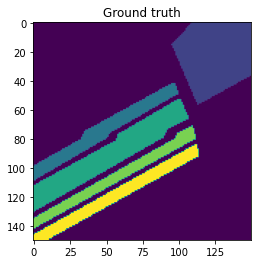

In [46]:
fig = plt.figure()
plt.imshow(labels)
plt.title('Ground truth')
plt.show()

#### As we can see from the 5 unmixing methods we followed, we got the minimun reconstruction error from the 1st method Least Squares (without restrictions).
#### Although, by looking at the abundance maps created from that mehtod, the 5 classes are not that clear to be distinguished, as it is in the methods Least Square (with restrictions).
#### So in that case we can be sure that the reconstruction error is not a successful metric to decide whether an unmixing method is giving good or bad results.

#### Now if we scroll down and check the abundance maps created for each method, we will see that the best results for seperating the 5 classes, that are close to the ground thuth plot, 
#### are the Least Squares methods with the non-negative restriction of θ, the Least Squares mehtods with both non-negative and sum to one restrictions of θ and Lasso with restriction for non-negative θ.

#### This is logical if we think that the θ corresponds to the percentage to which contributes to the formation of the pixel under study (as the project also reports).
#### Based on that 1st: we cannot have negative contribution to the formation of a pixel, so the non negative restriction make sense.
#### Also, the θ should sum up to one since we its not logical to contribute to the formation of more then 100% of the image we are given.

#### Finally using the LASSO method, we have implement 2 LASSO methods with different parameters and its pretty intresting to check the results.
#### First we have the default LASSO that as the sk-learn mentions is the same like the Least Squares method (alpha = 1)
#### Next we run the LASSO with parameters alpha much higher, so we can increase the controlling regularization strength of the model,
#### and the parameter "positive = True" which actually implement the logical restriction for non-negative coefficients, which as we explained before is completly logical.

#### Comparing the two LASSO methods, we can see that the one with the parameters added is much more clear and close to the Least Square with restriction methods.

# CLASSIFICATION

## (A)

### Here we will filter our datasets so we can keep the constrain that we consider also the image pixels with non zero class label.
### By doing so our data transform to 1 column array, so it came handy so now are ready and transformed as it needs for the classification methods.

In [28]:
X_train = HSI[Training_Set!=0]
y_train = Training_Set[Training_Set!=0]

X_test  = HSI[Test_Set!=0]
y_test = Test_Set[Test_Set!=0]

X_oper = HSI[Operational_Set!=0]
y_oper = Operational_Set[Operational_Set!=0]

## NB Classifier

In [29]:
clf = GaussianNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2165 points : 34


In [30]:
NB_score = cross_val_score(GaussianNB(), X_train, y_train, cv = 10)
NB_error = 1 - NB_score
NB_mean = round(NB_error.mean(),3)
NB_std = round(NB_error.std(),3)
print('Naive Bayes mean validation error is:', NB_mean)
print('Naive Bayes error standard deviation is:', NB_std)

Naive Bayes mean validation error is: 0.018
Naive Bayes error standard deviation is: 0.014


In [31]:
NB_pred = clf.fit(X_train, y_train).predict(X_test)
NB_cm = confusion_matrix(y_test, NB_pred)
print('Naive Bayes Confusion Matrix:')
print(NB_cm)

NB_score = np.trace(NB_cm)/ np.sum(NB_cm)
print('Naive Bayes classifier success rate is:',round(NB_score,4))

Naive Bayes Confusion Matrix:
[[652   0   0   0   0]
 [  0 333   8   0   1]
 [  0   1 548   0   0]
 [  0   0   0 267   8]
 [  0   2   0  14 331]]
Naive Bayes classifier success rate is: 0.9843


## Euclidean distance classifier

### Since there is not an already implemented solution - library for the Euclidean Distance Classifier, we need to create one by scratch.
### If we think the Euclidean Distance Classifier is actually computes the straight distance between the given pixel and each class mean.
### So we need to calculate the mean of each class, we are doing so by using the GaussianMixture, and then we calculate the Euc Distance so we can find the minimum,
### and classify the pixel to the class with the minimum Euclidean Distance.

In [32]:
class Euc_Distance_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, metric='euclidean'):
        self.class_list = {}
        self.mu = []
        self.metric = metric

    def fit(self, X, y):
        self.class_list = np.unique(y, axis=0)
        self.mu = np.zeros((len(self.class_list),X.shape[1]))
        for i in range(len(self.class_list)):
            # fit the GMM with 1 component to calculate the mean for each class
            gm = GaussianMixture(n_components=1, random_state=0).fit(X[y==i+1])
            self.mu[i] = gm.means_[0]
        return self

    def predict(self, X):
        temp = np.argmin(distance.cdist(X, self.mu, metric=self.metric),axis=1) # distance between each pair
        #of the collections of inputs
        y_pred = np.array([self.class_list[i] for i in temp])
        return y_pred

In [33]:
clf = Euc_Distance_Classifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2165 points : 53


In [34]:
clf = Euc_Distance_Classifier()

In [35]:
clf.fit(X_train,y_train)

Euc_Distance_Classifier()

In [36]:
euc_pred = clf.predict(X_test)

In [37]:
euc_score = cross_val_score(clf, X_train, y_train, cv = 10)
euc_error = 1 - euc_score
euc_mean = round(euc_error.mean(),4)
euc_std = round(euc_error.std(),4)

print('Minimum Euclidea Distance Classifier mean validation error is:', euc_mean)
print('Minimum Euclidea Distance Classifier error standard deviation is:', euc_std)

Minimum Euclidea Distance Classifier mean validation error is: 0.0284
Minimum Euclidea Distance Classifier error standard deviation is: 0.0181


In [38]:
euc_cm = confusion_matrix(y_test, euc_pred)
print('Euclidea Distance Classifier Confusion Matrix:')
print(euc_cm)

euc_score = np.trace(euc_cm)/ np.sum(euc_cm)
print('Euclidea Distance Classifier success rate is:',round(euc_score,4))

Euclidea Distance Classifier Confusion Matrix:
[[652   0   0   0   0]
 [  0 321  21   0   0]
 [  0   0 549   0   0]
 [  0   0   0 270   5]
 [  0   2   0  25 320]]
Euclidea Distance Classifier success rate is: 0.9755


## KNN Classifier

In [39]:
clf = KNeighborsClassifier(n_neighbors=5)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2165 points : 38


In [40]:
knn_score = cross_val_score(clf, X_train, y_train, cv = 10)
knn_error = 1 - knn_score
knn_mean = round(knn_error.mean(),3)
knn_std = round(knn_error.std(),3)
print('K-nearest neighbor mean validation error is:', knn_mean)
print('K-nearest neighbor error standard deviation is:', knn_std)

K-nearest neighbor mean validation error is: 0.01
K-nearest neighbor error standard deviation is: 0.008


In [41]:
knn_pred = clf.fit(X_train, y_train).predict(X_test)
knn_cm = confusion_matrix(y_test, knn_pred)
print('K-nearest neighbor Confusion Matrix:')
print(knn_cm)

knn_score = np.trace(knn_cm)/ np.sum(knn_cm)
print('K-nearest neighbor classifier success rate is:',round(knn_score,4))

K-nearest neighbor Confusion Matrix:
[[652   0   0   0   0]
 [  0 328  14   0   0]
 [  0   0 549   0   0]
 [  0   0   0 265  10]
 [  0   2   0  12 333]]
K-nearest neighbor classifier success rate is: 0.9824


## (B)

### Now we will compare our classification methods. Since we used the same datasets and made cross validation we have the right to compare the results.

In [42]:
print('Naive Bayes Confusion Matrix:')
print(NB_cm)

print('Naive Bayes classifier success rate is:',round(NB_score,4))

Naive Bayes Confusion Matrix:
[[652   0   0   0   0]
 [  0 333   8   0   1]
 [  0   1 548   0   0]
 [  0   0   0 267   8]
 [  0   2   0  14 331]]
Naive Bayes classifier success rate is: 0.9843


In [43]:
print('Euc_Distance_Classifier Confusion Matrix:')
print(euc_cm)

print('Euc_Distance_Classifier classifier success rate is:',round(euc_score,4))

Euc_Distance_Classifier Confusion Matrix:
[[652   0   0   0   0]
 [  0 321  21   0   0]
 [  0   0 549   0   0]
 [  0   0   0 270   5]
 [  0   2   0  25 320]]
Euc_Distance_Classifier classifier success rate is: 0.9755


In [44]:
print('K-nearest neighbor Confusion Matrix:')
print(knn_cm)

print('K-nearest neighbor classifier success rate is:',round(knn_score,4))

K-nearest neighbor Confusion Matrix:
[[652   0   0   0   0]
 [  0 328  14   0   0]
 [  0   0 549   0   0]
 [  0   0   0 265  10]
 [  0   2   0  12 333]]
K-nearest neighbor classifier success rate is: 0.9824


### As we can see all three classifiers did perform very well with 97.5%  success rate and more.

### Now if we look at the Confusion Matrices, we can see that there are 3 spesific areas that all three classifiers gets it not so much successfully.
### For all the three cases the classifier classifies few pixels to the next class. 
### For class 4 & 5 we can see that miss classifies in both cases, while for class 2 & 3 the classifier miss classifies only from class 2 to class 3 and not the other 
### way as it does for classes 4 & 5.

## (C)

#### So the problem here is asking if we could use the Bayesian Classifier with the assumption of normallity for the classes of our problem.
#### In that case the significant difference would come from our assumptions about the covariances.
#### The first issue may be that by trying to calculte the inverse covariance matrices, they may not exist. 
#### Also we may have issue with the singularity, due to the number of dimentions (features) and the number of our sample being close enough.
### This may lead to an overfitting solution that is not wanted.

# Part 3

### Now lets talk about the result of the analysis above.
### The first part was the spectral unmixing. We got the abundance maps for each endmember of the image.
### The second part was the classification. This method assigned each of the pixels of the image to a class.

### The two methods are not much different from each other. In practice the results obtained from the spectral unmixing should be similar with the results obtained by the classification. 
### So when we find an endmbember with the highest contribution percentage for the image from the spectral unmixing, then this should be assigned by the classifier to the same class.

### So in our specific problem here, we can combine the to part of the project, by using the methods that resulted the best. For the spectral unmixing we can say are the methods that involved the restriction of 
### non-negative coefficient, and for the classification the best score is resulted from Naive Bayes classifier with infinitesimal difference from KNN classifier.

## Thank you for your time and consideration please contanct me for any question may occur.
## Charalampos Sykianakis MSc Data Science AUEB candidate.